# ALFA-BD - Predição da Avaliação de Fluência em Leitura com SVM

## Leitura de texto dos Alunos do 2ª e 3º Anos do Fundamental

#### Autor: TS#03


### Algoritmo SVM (Support Vector Machine)

Referencia: https://scikit-learn.org/stable/modules/svm.html

#### Bibliotecas

In [1]:
import glob
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict, train_test_split

%matplotlib inline

## Carregamento da Base de Dados

In [2]:
files = glob.glob('dataset/*.wav')
files

['dataset/9_3_publica_menina_regular.wav',
 'dataset/3_2_publica_menina_bom.wav',
 'dataset/11_2_publica_menino_regular.wav',
 'dataset/12_3_publica_menino_regular.wav',
 'dataset/6_2_publica_menino_ruim.wav',
 'dataset/1_2_particular_menina_regular.wav',
 'dataset/5_2_publica_menina_regular.wav',
 'dataset/7_3_particular_menina_bom.wav',
 'dataset/4_2_publica_menino_ruim.wav',
 'dataset/8_3_particular_menino_regular.wav',
 'dataset/2_2_particular_menino_regular.wav',
 'dataset/13_3_publica_menino_regular.wav',
 'dataset/10_3_publica_menina_regular.wav']

## Pré Processamento

Extração das features dos áudios utilizando MFCC. Mel-Frequency Cepstral Coefficients que analisa características espectrais de tempo curto, baseando-se no uso de uma escala de frequências que imita as características únicas do som que são perceptíveis pelo ouvido humano.

In [3]:
classes = {'bom': 0, 'regular': 1, 'ruim': 2}
n_mfcc = 12
X = []
y = []

for file in files:
    
    label = classes[file.split('_')[4].replace('.wav', '')]
    x, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=n_mfcc).T
    X.append(mfcc)
    
    if label == 0:
        y.append(np.zeros(len(mfcc)))
    elif label == 1:
        y.append(np.ones(len(mfcc)))
    else:
        y.append(np.full(len(mfcc), 2))

In [4]:
X = np.vstack(tuple(X))
y = np.concatenate(tuple(y))

## Treinamento e Teste

Obs: Desconsideramos o Kernel Linear pois na primeira execução ele não teve um bom resultado e desempenho

In [5]:
# Criação dos pipelines
pipe_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

pipe_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='poly'))
])

pipe_3 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC())
])

pipe_4 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(kernel='poly'))
])

SVM = [{'name': 'RBF (StandardScaler)',        'pipeLine': pipe_1},
       {'name': 'Polinomial (StandardScaler)', 'pipeLine': pipe_2},
       {'name': 'RBF (MinMaxScaler)',          'pipeLine': pipe_3},
       {'name': 'Polinomial (MinMaxScaler)',   'pipeLine': pipe_4},]

In [6]:
def crossValidade(clf, X, y):
    predictions = cross_val_predict(clf, X, y, cv=10)
    
    print (classification_report(y, predictions, labels=[0, 1, 2]))
    
    cm = confusion_matrix(predictions, y)
    print (f'Confusion Matrix:\n{cm}')
    #sns.heatmap(cm, annot=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [ ]:
for pipe in SVM:
    print ('\n---> '+ pipe['name'])
    
    print ('\n1. Cross Validade\n')
    
    crossValidade(pipe['pipeLine'], X, y)

    print ('\n2. Evaluation\n')
    
    classifier = pipe['pipeLine'].fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    
    print (classification_report(y_test, predictions, labels=[0, 1, 2]))
    
    cm = confusion_matrix(predictions, y_test)
    print (f'Confusion Matrix:\n{cm}')
    #sns.heatmap(cm, annot=True)


---> RBF (StandardScaler)

1. Cross Validade

              precision    recall  f1-score   support

           0       0.74      0.52      0.61     12381
           1       0.79      0.86      0.82     69334
           2       0.54      0.48      0.51     21675

    accuracy                           0.74    103390
   macro avg       0.69      0.62      0.65    103390
weighted avg       0.73      0.74      0.73    103390

Confusion Matrix:
[[ 6435  1720   516]
 [ 5134 59743 10853]
 [  812  7871 10306]]

2. Evaluation

              precision    recall  f1-score   support

           0       0.86      0.55      0.67      2476
           1       0.82      0.96      0.88     13867
           2       0.80      0.53      0.63      4335

    accuracy                           0.82     20678
   macro avg       0.83      0.68      0.73     20678
weighted avg       0.82      0.82      0.80     20678

Confusion Matrix:
[[ 1363   134    86]
 [ 1018 13253  1968]
 [   95   480  2281]]

---> Polin

## Definindo melhores parâmetros para o modelo

Os parâmetros tem forte impacto no comportamento e otimização do modelo

In [9]:
from sklearn.model_selection import GridSearchCV

# Parametros
C= [0.001, 0.01, 0.1, 1, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10, 100]
params_grid = dict(clf__C=C, clf__gamma=gamma)

In [ ]:
# Ultilizamos o pipe_1 que deve os melhores resultados
grid = GridSearchCV(pipe_1, params_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

## Sobreamostragem (oversampling)

Técnica para imputar dados em datasets desbalanceados, cria-se amostras sintéticas utilizando algoritmos baseados em calculos de similaridade.

#### Criando amostras sintéticas para as classes minoritárias

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
smote = SMOTE()
X_over, y_over = smote.fit_resample(X, y)

In [10]:
X_over.shape, y_over.shape

((208002, 12), (208002,))

In [11]:
np.unique(y, return_counts=True)

(array([0., 1., 2.]), array([12381, 69334, 21675]))

In [12]:
np.unique(y_over, return_counts=True)

(array([0., 1., 2.]), array([69334, 69334, 69334]))

#### Retreinando o modelo

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     13867
           1       0.86      0.73      0.79     13867
           2       0.80      0.89      0.84     13867

    accuracy                           0.84     41601
   macro avg       0.84      0.84      0.84     41601
weighted avg       0.84      0.84      0.84     41601



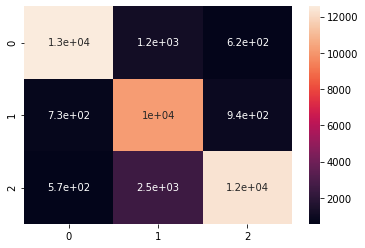

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over)

classifier = pipe_1.fit(X_train, y_train)
predictions = classifier.predict(X_test)
    
print (classification_report(y_test, predictions, labels=[0, 1, 2]))
    
cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, annot=True);

####  Salvando o modelo

In [14]:
import pickle

with open("classifier.pickle","wb") as f:
    pickle.dump(classifier, f) 

## Conclusões

Com a utilização da escala MFCC é possível obter caracteristicas especificas do áudio e ter um resultado satisfatório em comparação ao modelo de processamenteo de texto.

Para um teste completo seria interessante aplicar oversampling antes de executar validação cruzada em cada conversão de escala dos dados e kernel.